Finding a wind stress that produces realistic Mackenzie Shelf current velocities.

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions


from salishsea_tools.nc_tools import scDataset

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from matplotlib import animation

from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap

## Functions

In [2]:
def get_files(dirname, fname, grid):
    files = []    
    for item in os.listdir(dirname):
        if fnmatch.fnmatchcase(item, fname + grid + "*.nc"):
            files += [os.path.join(dirname, item)]
    files.sort(key=os.path.basename)
    return files

In [3]:
def U_timeseries(dirname, fname, x_start, x_end, y_start, y_end):
    
    filesU = get_files(dirname, fname, 'grid_U')
    
    y = slice(y_start, y_end, None)
    x = slice(x_start, x_end, None)

    with scDataset(filesU) as dsU:
        vozocrtx0 = dsU.variables['vozocrtx'][:,:,y,x]
        print('U')
        sozotaux = dsU.variables['sozotaux'][:,0,0]
        depthu = dsU.variables['depthu'][:]

    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        umask0 = dsM.variables['umask'][0,:,y,x]

    umask = np.tile(umask0, (len(sozotaux),1, 1, 1))

    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    
    return vozocrtx, umask, depthu, sozotaux

In [4]:
def get_speeds(U_vel, V_vel, dep, time_ind, arrow):
    '''This function unstaggers the velocity components
    and calculates the speeds at arrow intervals.
    
    #from /ocean/imachuca/Canyons/mackenzie_canyon/tools/functions_velocity.py
    '''
    ugrid = U_vel[time_ind, dep, :, :]
    vgrid = V_vel[time_ind, dep, :, :]
    u_nstg0 = (np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2)[..., 1:, :]
    v_nstg0 = (np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2)[..., 1:]
    u_nstg = u_nstg0[::arrow,::arrow]
    v_nstg = v_nstg0[::arrow,::arrow]
    x_slice = np.arange(1, ugrid.shape[1])[::arrow]
    y_slice = np.arange(1, ugrid.shape[0])[::arrow]
    speeds = np.sqrt(u_nstg**2 + v_nstg**2)
    return speeds

In [5]:
def load_vozocrtx(dirname, fname, x_start, x_end, y_start, y_end):
    
    # load masks for wheat in final plot
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        umask_all = dsM.variables['umask'][0,:,:,:]

    # load grid_U files and U velocity (t, z, y, x)
    vozocrtx, umask, depthu, sozotaux = U_timeseries(dirname, fname, x_start, x_end, y_start, y_end)

    return vozocrtx, umask, umask_all, depthu, sozotaux

def calculate_avgU(vozocrtx, dep_start, dep_end):

    # find avg U for every row in the y direction
    avgU_all_ys = np.mean(np.mean(vozocrtx, axis=-1), axis=-2)

    # find avg U within horizontal rectangle for all depths (time, z)
    avgU_all_depths = np.mean(np.mean(vozocrtx, axis=-1), axis=-1)

    # find avg U for every depth within the box
    avgU_box_depths = avgU_all_depths[:, dep_start : dep_end+1]

    # find the absolute avg U within the box
    avgU_absolute = np.mean(avgU_box_depths, axis=-1)
    
    return avgU_all_ys, avgU_all_depths, avgU_box_depths, avgU_absolute

In [6]:
def plot_this_pair(axa, axb, plot_avgU, inds_absolute, ttl):
    cm_times = np.linspace(0, 1, plot_avgU.shape[-1])
    colors = [cm.Spectral_r(x) for x in cm_times]

    for ind, c, ind_absolute in zip(np.arange(plot_avgU.shape[-1]), colors, inds_absolute):
        if ind == 0 or ind == plot_avgU.shape[-1]-1:
            axa.plot(plot_avgU[:, ind], c=c, lw=2, label='ind = '+str(ind_absolute))
            axb.plot(general_functions.smooth(plot_avgU[:, ind], 12), c=c, lw=2, label='ind = '+str(ind_absolute))
        else:
            axa.plot(plot_avgU[:, ind], c=c, lw=2)
            axb.plot(general_functions.smooth(plot_avgU[:, ind], 12), c=c, lw=2)
            
    for ax, ttl_add in zip([axa, axb], [' (Original)', ' (Smoothed)']):
        ax.set_xlim([0, plot_avgU.shape[0]])
        ax.set_ylim([-0.2, 0.2])
        ml = MultipleLocator(24)
        ax.xaxis.set_minor_locator(ml)
        ax.xaxis.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
        ax.set_title('Evolution of '+ttl+ttl_add, fontsize=20)
        ax.set_xlabel('Time [hrs]', fontsize=12)
        ax.legend(ncol=2, fontsize=15)
    return axa, axb

In [7]:
def plot_story(umask_all, y_start, y_end, x_start, x_end, dep_start, dep_end, avgU_absolute):
    cmap = LinearSegmentedColormap.from_list('mycmap', ['wheat', 'white'])

    xs = np.arange(umask_all.shape[-1]) * 2/3
    ys = np.arange(umask_all.shape[-2]) *2/3
    zs = np.arange(umask_all.shape[-3])

    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 2])

    ax1 = plt.subplot(gs[0])
    ax4 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[3])

    s = ax1.pcolormesh(xs, ys, umask_all[9, :,:], cmap=cmap)
    ax1.set_aspect(aspect='equal')
    ax1.add_patch(patches.Rectangle((x_start*2/3, y_start*2/3),(x_end-x_start)*2/3,(y_end-y_start)*2/3, 
                                    fill=False, linewidth=3))
    ax1.set_xlim([0, xs[-1]])
    ax1.set_ylim([0, ys[-1]])
    ax1.set_xlabel('Alongshore Distance [km]', fontsize = 15)
    ax1.set_ylabel('Cross-shore Distance [km]', fontsize = 15)

    sc = ax3.pcolormesh(ys, zs, umask_all[:, :, x_start], cmap=cmap)
    ax3.add_patch(patches.Rectangle((y_start*2/3, dep_start),(y_end-y_start)*2/3, dep_end-dep_start, fill=False, linewidth=3))
    ax3.set_ylim([zs[-1], 0])
    ax3.set_xlim([0, ys[-1]])
    ax3.set_ylabel('Z Indices', fontsize = 15)
    ax3.set_xlabel('Cross-shore Distance [km]', fontsize = 15)

    avgU_absolute_smoothed = general_functions.smooth(avgU_absolute[:], 12)
    ax2.plot(avgU_absolute, c='gray', lw=2, alpha=0.8)
    ax2.plot(avgU_absolute_smoothed, c='k', lw=2)
    ax2.set_title('Incoming Velocity', fontsize=20)
    ax2.set_xlabel('Time [hours]', fontsize=15)
    ax2.set_ylabel('[ms$^{-1}$]', fontsize=20)
    ax2.set_xlim([0, 480])
    ax2.set_ylim([-0.1, 0.1])
    ml = MultipleLocator(24)
    ax2.xaxis.set_minor_locator(ml)
    ax2.xaxis.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax2.axhline(0, linestyle='--', c='gray')

    ax4.plot(sozotaux, c='k', lw=2)
    ax4.set_title('Wind Stress', fontsize=20)
    ax4.set_xlabel('Time [hours]', fontsize=15)
    ax4.set_ylabel('[Nm$^{-2}$]', fontsize=20)
    ax4.set_xlim([0, 480])
    ax4.set_ylim([-0.15, 0.15])
    ml = MultipleLocator(24)
    ax4.xaxis.set_minor_locator(ml)
    ax4.xaxis.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax4.axhline(0, linestyle='--', c='gray')

    fig.tight_layout(w_pad=5.5, h_pad=3.5)
    
    print('min unsmoothed: ', avgU_absolute.min())
    print('min smoothed: ', avgU_absolute_smoothed.min())
    return fig

## Important Variables

In [8]:
x_start = 200; x_end = 230; y_start = 45; y_end = 190

dep_start = 2; dep_end = 6; dep_break = 9

## Wind Stress -0.15

In [9]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'
fname = "1_MCKNZ_1h_20170101_20170120_*"

vozocrtx, umask, umask_all, depthu, sozotaux = load_vozocrtx(dirname, fname, x_start, x_end, y_start, y_end)

avgU_all_ys, avgU_all_depths, avgU_box_depths, avgU_absolute = calculate_avgU(vozocrtx, dep_start, dep_end)

dep_inds_model = np.arange(vozocrtx.shape[-3])
dep_inds_box = np.arange(dep_start,dep_end+1)
y_inds = np.arange(y_start,y_end+1)

avgU_all_ys.shape, avgU_all_depths.shape, avgU_box_depths.shape, avgU_absolute.shape

U


((480, 145), (480, 80), (480, 5), (480,))

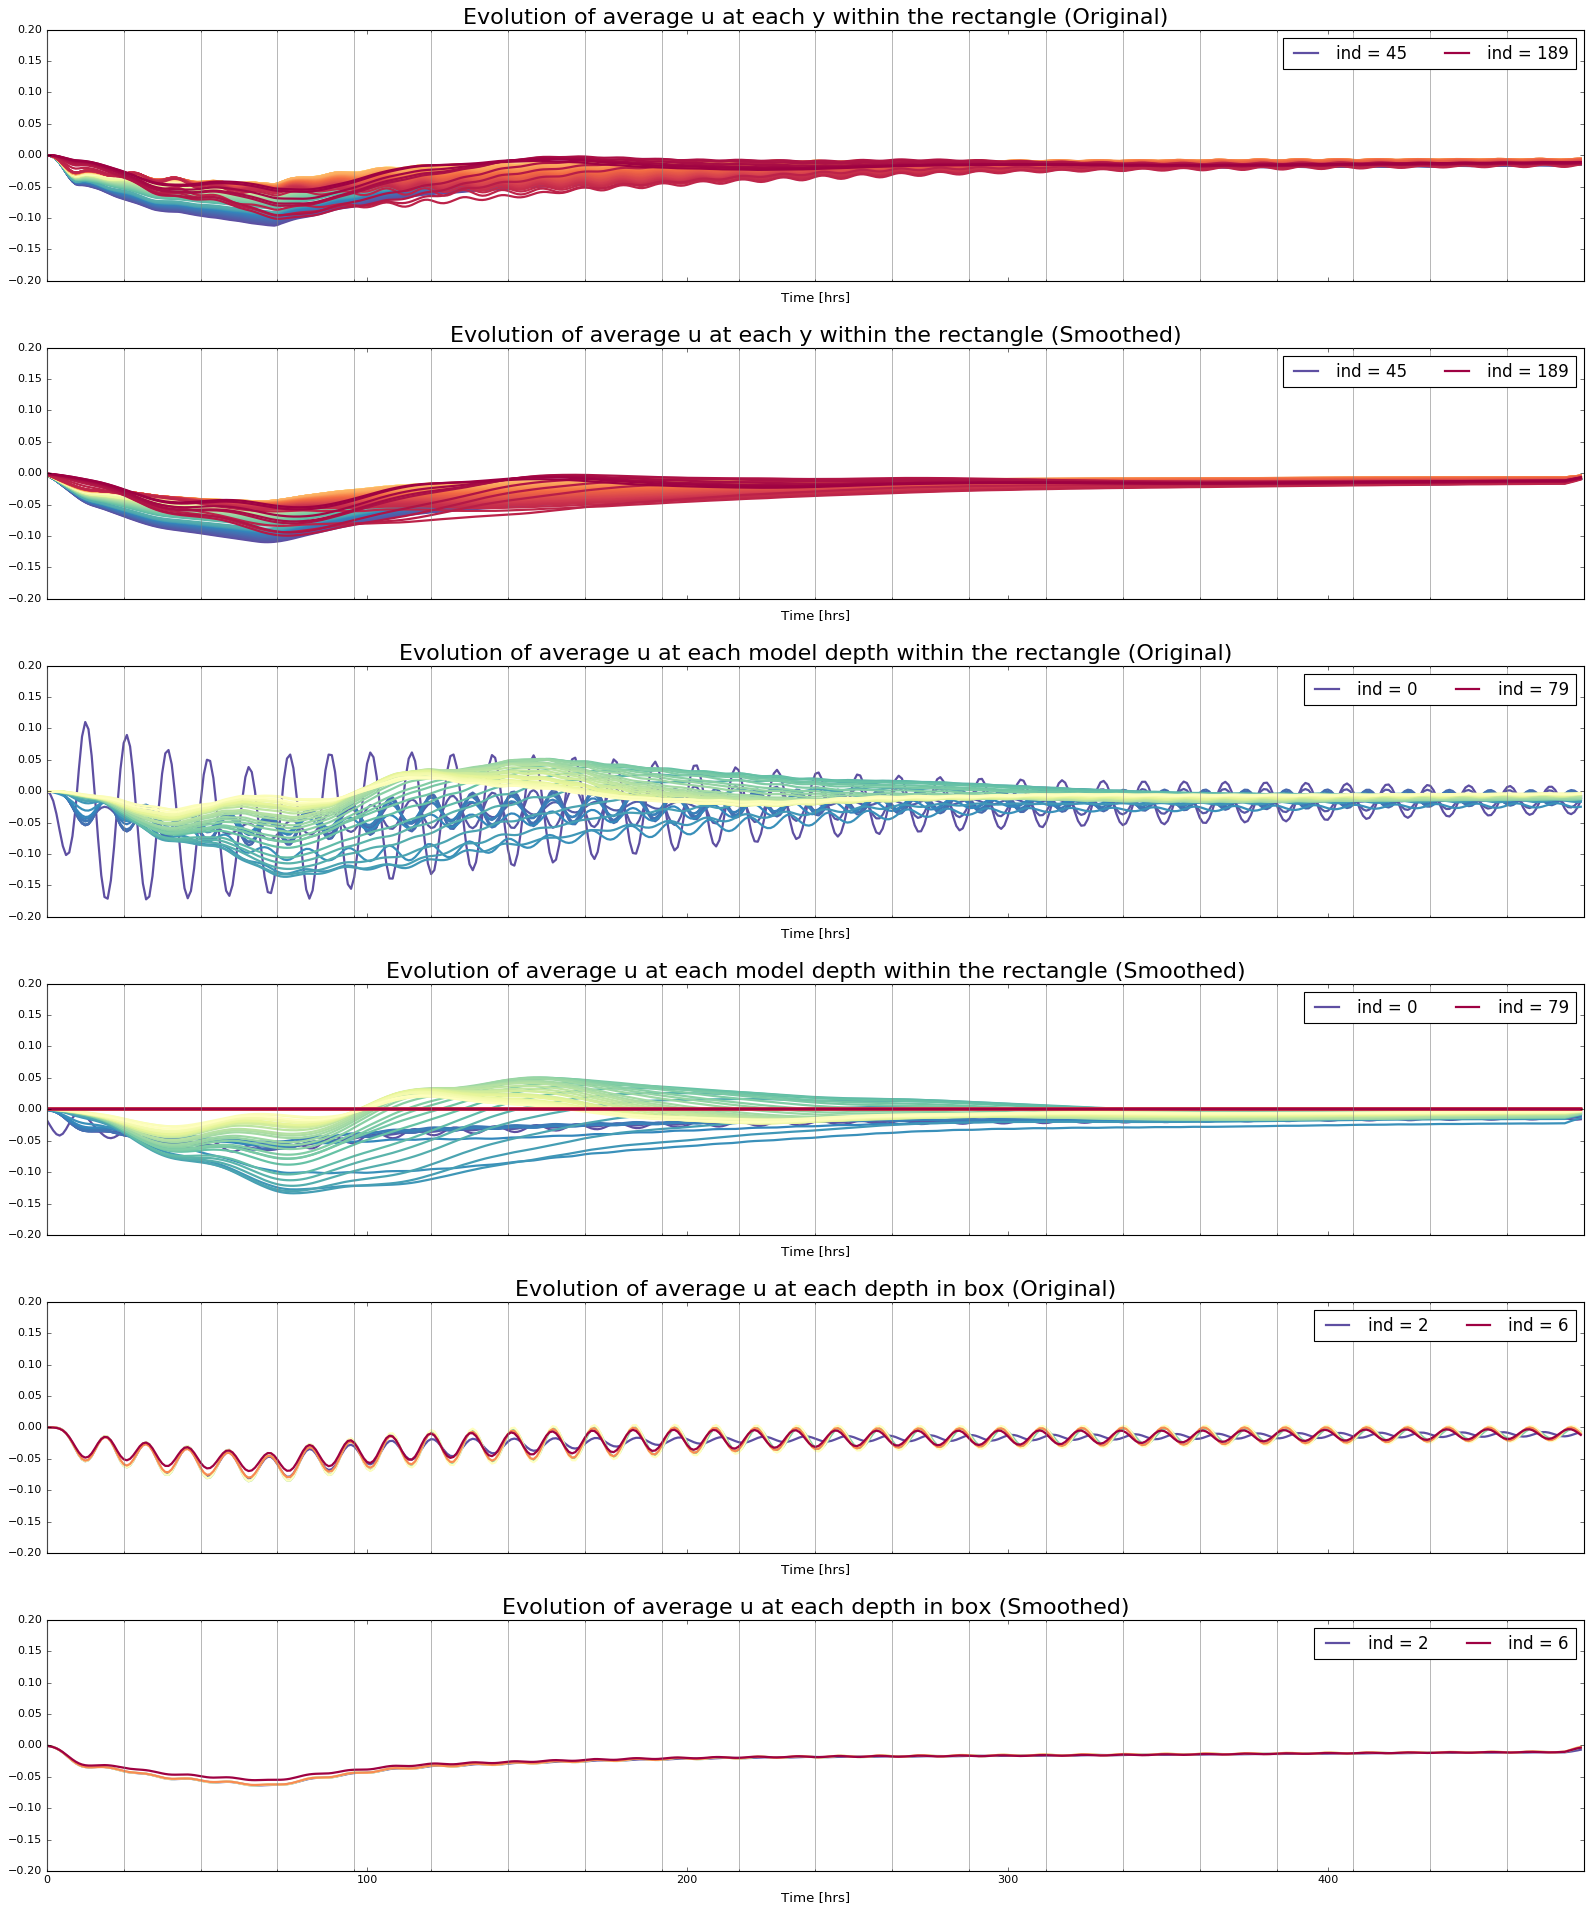

In [10]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6,1,figsize=(20, 24), sharex=True)

ax1, ax2 = plot_this_pair(ax1, ax2, avgU_all_ys, y_inds, 'average u at each y within the rectangle')
ax3, ax4 = plot_this_pair(ax3, ax4, avgU_all_depths, dep_inds_model, 'average u at each model depth within the rectangle')
ax5, ax6 = plot_this_pair(ax5, ax6, avgU_box_depths, dep_inds_box, 'average u at each depth in box')
fig.tight_layout(h_pad=2)

min unsmoothed:  -0.080508786916
min smoothed:  -0.061937614966


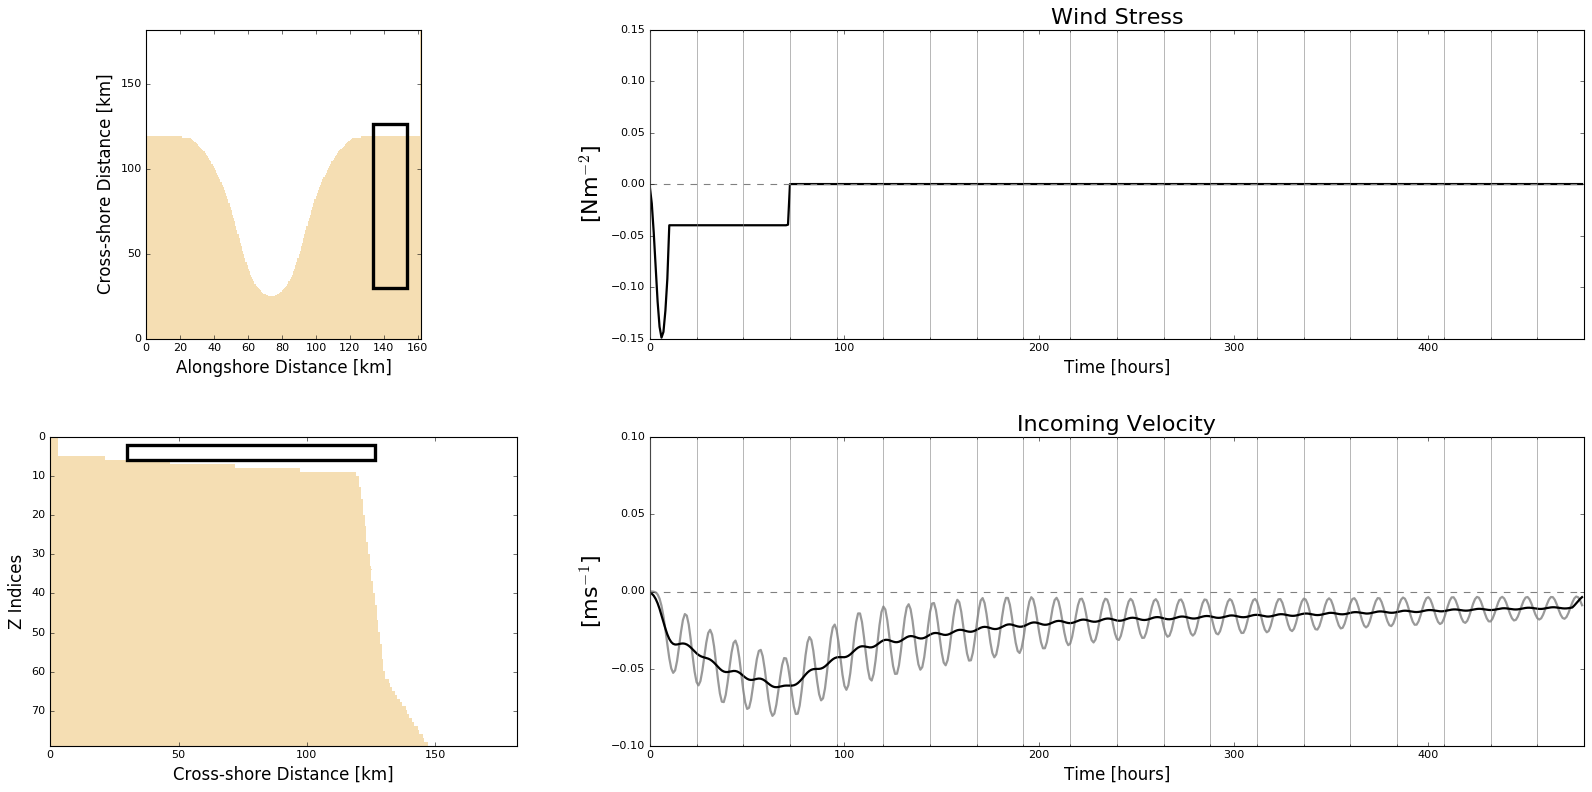

In [11]:
fig = plot_story(umask_all, y_start, y_end, x_start, x_end, dep_start, dep_end, avgU_absolute)

## Wind Stress -0.30

In [12]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/winds_incoming_velocities/stress_0.3_runB/'
fname = "1_MCKNZ_1h_20170101_20170105_*"

vozocrtx, umask, umask_all, depthu, sozotaux = load_vozocrtx(dirname, fname, x_start, x_end, y_start, y_end)

avgU_all_ys, avgU_all_depths, avgU_box_depths, avgU_absolute = calculate_avgU(vozocrtx, dep_start, dep_end)

dep_inds_model = np.arange(vozocrtx.shape[-3])
dep_inds_box = np.arange(dep_start,dep_end+1)
y_inds = np.arange(y_start,y_end+1)

avgU_all_ys.shape, avgU_all_depths.shape, avgU_box_depths.shape, avgU_absolute.shape

U


((120, 145), (120, 80), (120, 5), (120,))

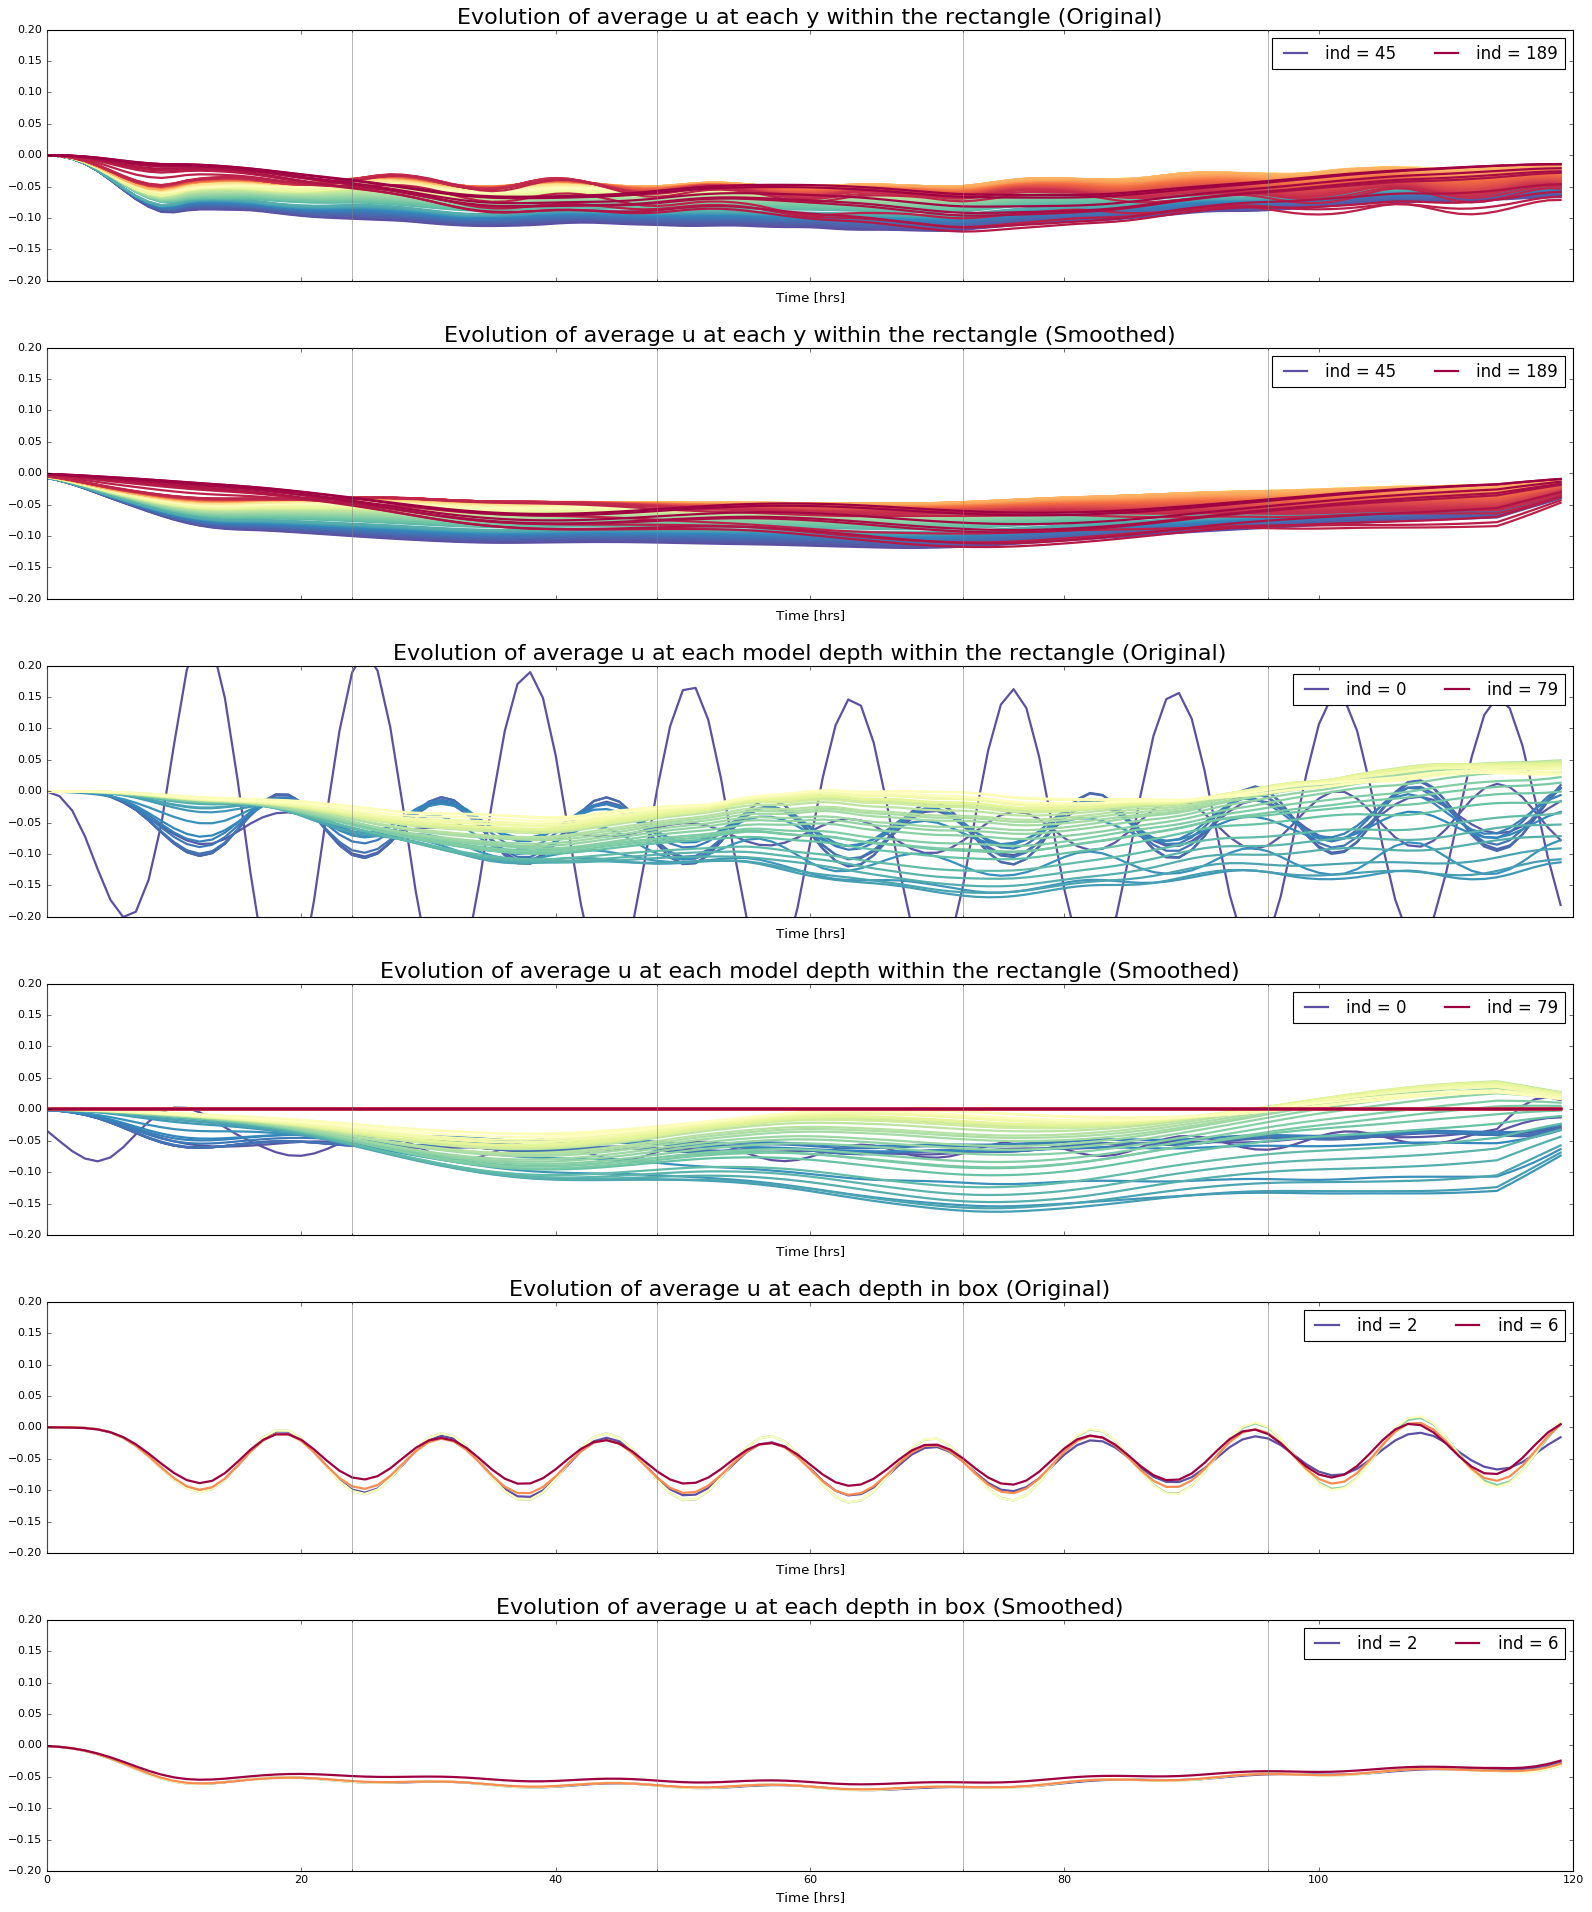

In [13]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6,1,figsize=(20, 24), sharex=True)

ax1, ax2 = plot_this_pair(ax1, ax2, avgU_all_ys, y_inds, 'average u at each y within the rectangle')
ax3, ax4 = plot_this_pair(ax3, ax4, avgU_all_depths, dep_inds_model, 'average u at each model depth within the rectangle')
ax5, ax6 = plot_this_pair(ax5, ax6, avgU_box_depths, dep_inds_box, 'average u at each depth in box')
fig.tight_layout(h_pad=2)

min unsmoothed:  -0.109540277778
min smoothed:  -0.0691853375381


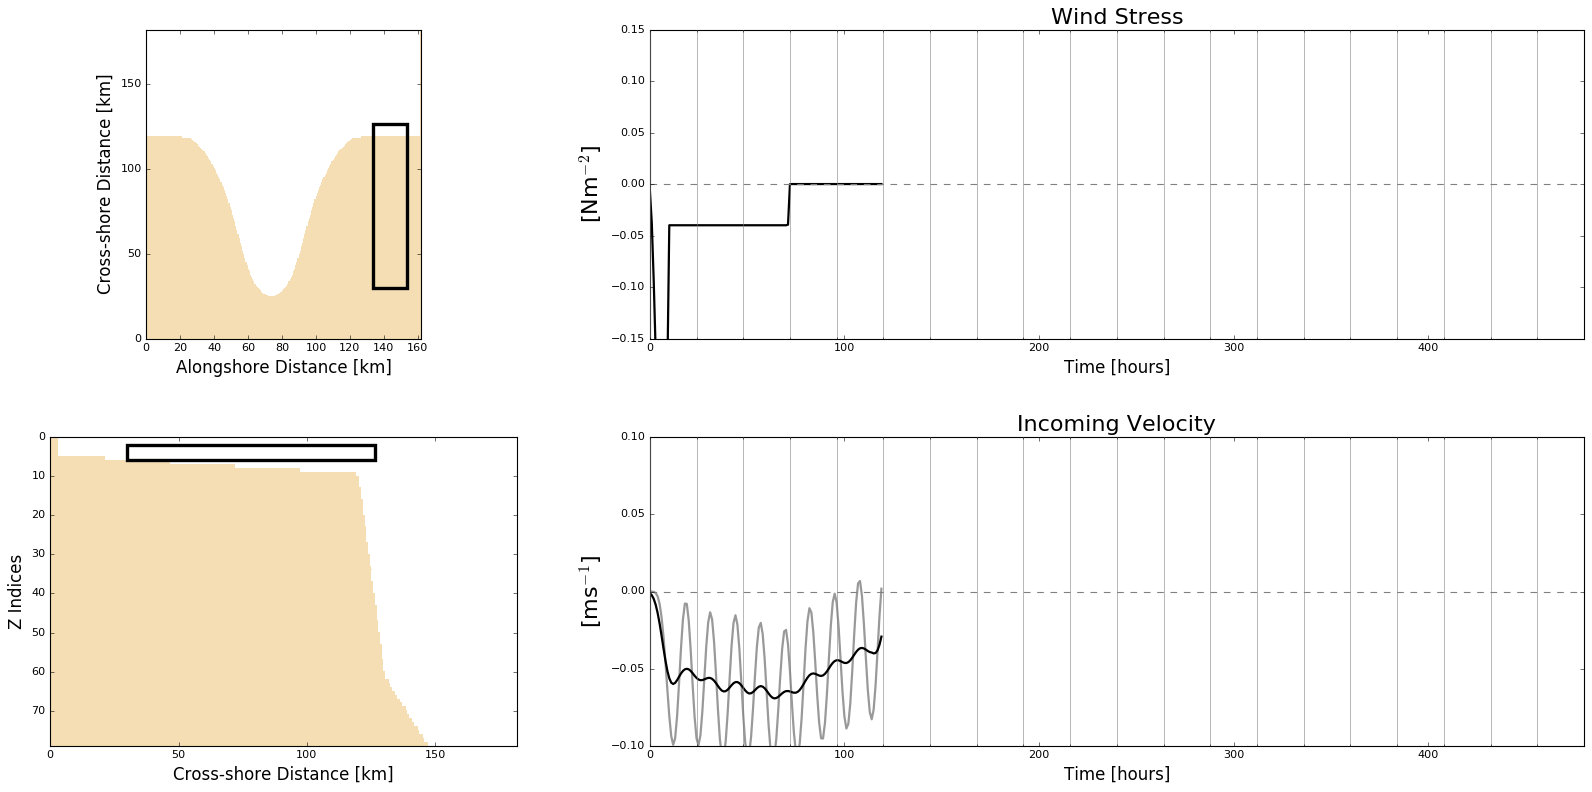

In [14]:
fig = plot_story(umask_all, y_start, y_end, x_start, x_end, dep_start, dep_end, avgU_absolute)